In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import multiprocessing

In [3]:
data = pd.read_csv('./data/train_data.csv')
label = pd.read_csv('./data/train_label.csv')

In [4]:
data['label'] = label['label']
data.head()

,desc,tweet,label
0,none,mariotti did your ancestors have to apply thro...,0
1,usmc veteran love god wife family dog and coun...,rule of law all the liberals including her wan...,0
2,none,rt japanmissionun thank you unicef unhcr nyoff...,0
3,we ve been referring people to law firms since...,know a good law firm in stirling immigration c...,0
4,i love life i love my family i love people,wall street ally with a skepticism of immigrat...,0


In [5]:
data.isnull().sum()

desc     27
tweet     0
label     0
dtype: int64

In [6]:
data = data.dropna().reset_index(drop = True)
data.isnull().sum()

desc     0
tweet    0
label    0
dtype: int64

In [7]:
data.shape

(1473, 3)

In [8]:
def tokenize(text):
    return [word for word in word_tokenize(text.lower()) if word not in stopwords.words('english')]

In [9]:
X = data['desc'] + ' ' + data['tweet']
Y = data['label']

In [10]:
clfs = [DecisionTreeClassifier(), SVC(), RandomForestClassifier(), BernoulliNB()]
clf_names = ['Decision Trees', 'Support Vector Machine', 'Random Forest', 'Naive Bayes']

In [11]:
feats = ['TF-IDF', 'PV-DM', 'PV-DBOW']

In [12]:
%%time
vectorizer = TfidfVectorizer(tokenizer = tokenize)
vectorized_data = vectorizer.fit_transform(X)

Wall time: 30.7 s


In [13]:
%%time
tagged_data = [TaggedDocument(words = tokenize(_d), tags=[str(i)]) for i, _d in enumerate(X)]

Wall time: 30.1 s


In [14]:
cores = multiprocessing.cpu_count()

In [15]:
%%time
d2v_dm = Doc2Vec(tagged_data, dm=1, min_count=20, window=2, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)
d2v_dbow = Doc2Vec(tagged_data, dm=0, min_count=20, window=2, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=cores-1)

Wall time: 2min 5s


In [16]:
results = dict()
cross_val = dict()

In [17]:
def eval(clf_name, feat, y_test, predictions):
    scores = dict()
    
    if clf_name not in results:
        results[clf_name] = {'accuracy': [],
                             'macro_precision': [], 'macro_recall': [], 'macro_f1': [],
                             'micro_precision': [], 'micro_recall': [], 'micro_f1': []}
    
    results[clf_name]['accuracy'].append(accuracy_score(y_test, predictions))

    results[clf_name]['macro_precision'].append(precision_score(y_test, predictions, average='macro'))
    results[clf_name]['macro_recall'].append(recall_score(y_test, predictions, average='macro'))
    results[clf_name]['macro_f1'].append(f1_score(y_test, predictions, average='macro'))

    results[clf_name]['micro_precision'].append(precision_score(y_test, predictions, average='micro'))
    results[clf_name]['micro_recall'].append(recall_score(y_test, predictions, average='micro'))
    results[clf_name]['micro_f1'].append(f1_score(y_test, predictions, average='micro'))

In [18]:
def cross(clf, clf_name, feat, X_train, Y_train):
    kf = KFold(n_splits=10, random_state = 42, shuffle = True)
    scores = cross_val_score(clf, X_train, Y_train, cv = kf)
    
    if clf_name not in cross_val:
        cross_val[clf_name] = {feat: scores}
    else:
        cross_val[clf_name].update({feat: scores})

In [19]:
def split(X, Y):
    return train_test_split(X, Y, test_size = .4, shuffle = False)

In [20]:
def train_tfidf(clf, clf_name, X, Y):
    X_train, X_test, Y_train, Y_test = split(X, Y)
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_test)
    
    cross(clf, clf_name, feats[0], X_train, Y_train)
    eval(clf_name, feats[0], Y_test, predictions)

In [21]:
def train_d2v(model, feat, clf, clf_name, X, Y):
    X_train, X_test, Y_train, Y_test = split(X, Y)
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for i in range(X_train.shape[0]):
        x_train.append(model[str(i)])
        y_train.append(Y_train[i])
    
    for i in range(X_test.shape[0]):
        x_test.append(model[str(i + X_train.shape[0])])
        y_test.append(Y_test[i + X_train.shape[0]])
        
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    
    cross(clf, clf_name, feat, x_train, y_train)
    eval(clf_name, feat, y_test, predictions)

In [22]:
%%time
for i in range(len(clfs)):
    train_tfidf(clfs[i], clf_names[i], vectorized_data, Y)
    train_d2v(d2v_dm, feats[1], clfs[i], clf_names[i], X, Y)
    train_d2v(d2v_dbow, feats[2], clfs[i], clf_names[i], X, Y)

Wall time: 19.9 s


In [23]:
for c in results:
    print('\nClassifier: {}'.format(c))
    print('\n\t\t\t{}\t\t{}\t\t{}\n'.format(feats[0], feats[1], feats[2]), '-' * 64)
    for s in results[c]:
        print('{:20s}:\t{:f}\t{:f}\t{:f}'.format(s, results[c][s][0], results[c][s][1], results[c][s][2]))


Classifier: Decision Trees

			TF-IDF		PV-DM		PV-DBOW
 ----------------------------------------------------------------
accuracy            :	0.862712	0.794915	0.810169
macro_precision     :	0.573577	0.509644	0.504224
macro_recall        :	0.580185	0.515926	0.506111
macro_f1            :	0.576611	0.506631	0.502425
micro_precision     :	0.862712	0.794915	0.810169
micro_recall        :	0.862712	0.794915	0.810169
micro_f1            :	0.862712	0.794915	0.810169

Classifier: Support Vector Machine

			TF-IDF		PV-DM		PV-DBOW
 ----------------------------------------------------------------
accuracy            :	0.915254	0.915254	0.915254
macro_precision     :	0.457627	0.457627	0.457627
macro_recall        :	0.500000	0.500000	0.500000
macro_f1            :	0.477876	0.477876	0.477876
micro_precision     :	0.915254	0.915254	0.915254
micro_recall        :	0.915254	0.915254	0.915254
micro_f1            :	0.915254	0.915254	0.915254

Classifier: Random Forest

			TF-IDF		PV-DM		PV-DBOW
 ---------

In [24]:
def bar_plot(clf_name, scores):
    index = np.arange(len(feats))
    plt.barh(index, scores, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
    plt.xlabel('Accuracy', fontsize = 10)
    plt.ylabel('Feature extraction method', fontsize = 10)
    plt.yticks(index, feats, fontsize = 10)
    plt.gcf().subplots_adjust(left = 0.25)
    plt.title(clf_name)
    plt.savefig('_'.join(clf_name.split()).lower() + '_acc.png')
    plt.show()

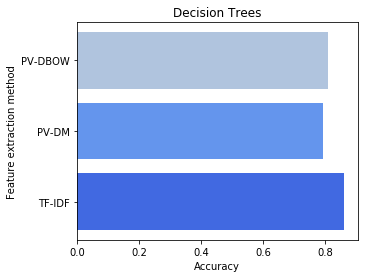

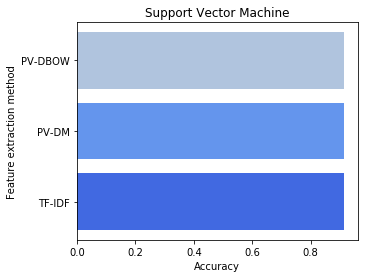

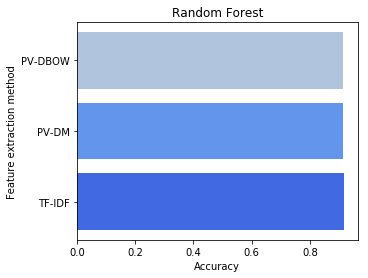

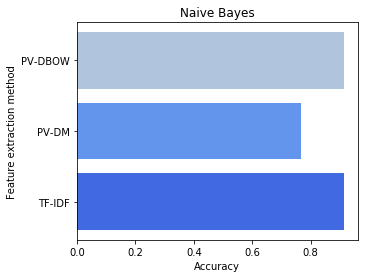

In [25]:
for c in results:
    clf_name = c
    scores = [results[c]['accuracy'][0], results[c]['accuracy'][1], results[c]['accuracy'][2]]
    bar_plot(clf_name, scores)

In [26]:
def fold_plot(clf_name):
    plt.xlabel('Fold as test set')
    plt.ylim(0.5, 1)
    plt.ylabel('Score')
    plt.plot(np.arange(1, 11), cross_val[clf_name]['TF-IDF'], color='blue')
    plt.plot(np.arange(1, 11), cross_val[clf_name]['PV-DM'], color='red', linestyle='dashed')
    plt.plot(np.arange(1, 11), cross_val[clf_name]['PV-DBOW'], color='green', linestyle='dotted')
    plt.legend(['TF-IDF', 'PV-DM', 'PV-DBOW'], loc='lower right')
    plt.title(clf_name)
    plt.savefig('_'.join(clf_name.split()).lower() + '_fold.png')
    plt.show()

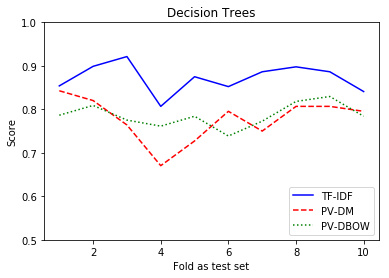

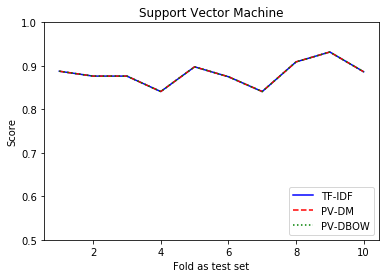

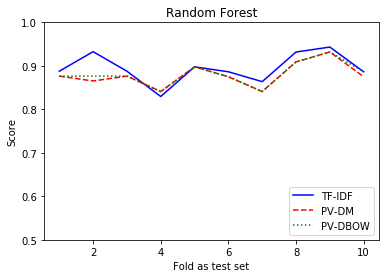

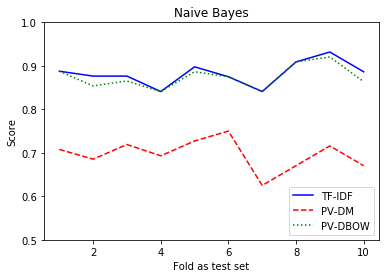

In [27]:
for c in cross_val:
    fold_plot(c)